불러온 FAISS 인덱스, 총 벡터 수: 105
===== BERTScore Evaluation =====

[1] 질문: 전주 대학교 인공지능학과의 설립 연도를 알려줘


model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

E:\anaconda\envs\chat1\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\taegyu\.cache\huggingface\hub\models--bert-base-multilingual-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


  - 정답(Reference): 전주대학교 인공지능학과는 2021년도에 신설되었으며, 4차 산업혁명 시대를 선도할 인공지능(AI) 전문가를 양성하기 위해 개설되었습니다.
  - 챗봇(Candidate): 전주대학교에서의 인공지능학과는 2021년에 설립되었습니다.
  - BERTScore (P, R, F1): (0.8957, 0.7604, 0.8225)

[2] 질문: 전주대학교 인공지능의 교육 과정을 알려줘줘
  - 정답(Reference): 전주대학교 인공지능 학과에서는 이론과 실무를 겸비한 교육을 통해 산업체 및 연구기관에서 요구하는 인공지능 전문 인재를 양성하고 있습니다. 각 학년별로 체계적인 교육 과정을 운영하며, 기초적인 프로그래밍부터 인공지능의 최신 기술까지 포괄적으로 다룹니다.

[교육 과정의 특징]
1. **기초 교육 (1~2학년 과정)**
   - 프로그래밍 기초와 데이터 분석 역량을 키우며, AI 및 컴퓨터 공학의 기초 개념을 학습합니다.
   - 파이썬, 자바 등 다양한 프로그래밍 언어와 확률 및 선형대수, 논리적 사고력 등을 배양합니다.

2. **심화 교육 (3~4학년 과정)**
   - 딥러닝, 강화학습, 자연어처리, 컴퓨터 비전 등의 고급 AI 기술을 학습하며, 실제 응용 사례를 다룹니다.
   - 프로젝트 기반의 실습을 통해 실무 경험을 쌓고, 클라우드, 빅데이터 분석, 로봇 프로그래밍 등 다양한 응용 분야를 접할 수 있습니다.

3. **산학 연계 프로그램 및 실습**
   - AI 리빙랩, 서비스러닝과 같은 실무 중심의 과목을 통해 기업 및 연구소와 협력하여 실무 프로젝트를 수행할 기회를 제공합니다.
   - 최신 AI 기술을 반영한 연구 프로젝트 및 캡스톤 디자인 과정도 운영됩니다.

4. **졸업 후 진로**
   - **AI 및 소프트웨어 관련 기업**: 삼성전자, LG전자, 네이버, 카카오, 엔씨소프트 등 대기업 및 IT 스타트업
   - **금융 및 데이터 분석 분야**: 은행, 증권사, 핀테크 기업 등 데이터 기반 

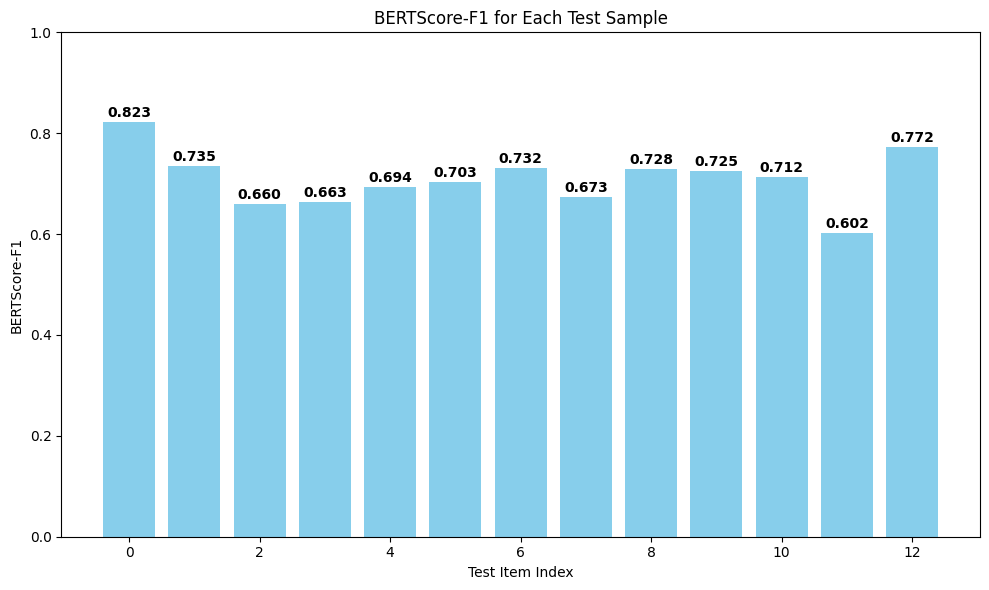

In [1]:
import os
import json
import numpy as np
import faiss
import re
from sentence_transformers import SentenceTransformer
from transformers import MarianMTModel, MarianTokenizer
import ollama
from bert_score import score  # BERTScore 계산
import matplotlib.pyplot as plt

# ========== 1. 설정: 프로젝트 경로 및 파일 경로 지정 ==========
base_dir = r"E:\deep_learning\THU\Capstone\7univ\02057\Capstone"   # 본인 환경에 맞게 수정

# JSON 데이터 및 FAISS 관련 파일 경로
combined_data_path = os.path.join(base_dir, "combined_data.json")
faiss_index_path   = os.path.join(base_dir, "faiss_index.bin")
test_data_path     = os.path.join(base_dir, "test.json")  # BERTScore 평가용

# Ollama 모델 이름
OLLAMA_MODEL = "qwen2.5:1.5b"

# ========== 2. 학교 별칭 설정 (정규화) ==========
school_aliases = {
    "jju": [
        r"전\s*주\s*대학교", r"전\s*주\s*대", r"전\s*대", r"전\s*주\s*대학",
        r"jeonju\s*uni", r"jeonju\s*university", r"JJU"
    ],
    "jnu": [
        r"전\s*남\s*대학교", r"전\s*남\s*대", r"전\s*남\s*대학", r"전남대",
        r"jeonnam\s*uni", r"jeonnam\s*university", r"jeonnam\s*national\s*university", r"JNU"
    ],
    "knu": [
        r"경\s*북\s*대학교", r"경\s*북\s*대", r"경\s*북\s*대학", r"경북대",
        r"kyungpook\s*uni", r"kyungpook\s*university", r"kyungpook\s*national\s*university", r"KNU"
    ],
    "skku": [
        r"성\s*균\s*관\s*대학교", r"성\s*균\s*관\s*대", r"성\s*대", r"성균관대",
        r"sungkyunkwan\s*uni", r"sungkyunkwan\s*university", r"SKKU"
    ],
    "tec": [
        r"서\s*울\s*과\s*학\s*기\s*술\s*대학교", r"서\s*울\s*과\s*학\s*기\s*술\s*대", 
        r"과\s*학\s*기\s*술\s*대학교", r"과\s*학\s*기\s*술\s*대", 
        r"과\s*기\s*대학교", r"과\s*기\s*대", r"서울과기대", r"SeoulTech",
        r"Seoul\s*National\s*University\s*of\s*Science\s*and\s*Technology", 
        r"Seoul\s*National\s*University", r"TEC"
    ],
    "uos": [
        r"서\s*울\s*시\s*립\s*대학교", r"서\s*울\s*시\s*립\s*대", r"시립대", 
        r"uni\s*of\s*Seoul", r"University\s*of\s*Seoul", r"UOS"
    ],
    "yj": [
        r"영\s*진\s*전\s*문\s*대학교", r"영\s*진\s*전\s*문\s*대", r"영진대", r"영진전문대",
        r"Yeungjin\s*University", r"Yeungjin\s*uni", r"YJU"
    ]
}

def normalize_school_names(text):
    """ 학교 이름을 일괄적으로 표준 키(key)로 치환 """
    for standard, aliases in school_aliases.items():
        for alias in aliases:
            text = re.sub(alias, standard, text, flags=re.IGNORECASE)
    return text

def get_school_key(school_name):
    """ 특정 문자열이 어느 학교 key에 해당하는지 반환 """
    for key, alias_list in school_aliases.items():
        if school_name.lower() == key.lower():
            return key
        for alias in alias_list:
            if re.fullmatch(alias, school_name, flags=re.IGNORECASE):
                return key
    return school_name

# ========== 3. 데이터 로드: JSON 데이터, FAISS 인덱스 불러오기 ==========
with open(combined_data_path, 'r', encoding='utf-8') as f:
    combined_data = json.load(f)

all_entries = combined_data.get("data_entries", []) + combined_data.get("image_entries", [])

doc_contents_kr = {entry["index"]: entry.get("content_kr", "") for entry in all_entries}
doc_contents_en = {entry["index"]: entry.get("content",    "") for entry in all_entries}

# FAISS 인덱스 로드
faiss_index = faiss.read_index(faiss_index_path)
print(f"불러온 FAISS 인덱스, 총 벡터 수: {faiss_index.ntotal}")

# ========== 4. 번역 모델 초기화 (한국어→영어) ==========
def load_translation_model():
    model_name = "Helsinki-NLP/opus-mt-ko-en"
    tokenizer = MarianTokenizer.from_pretrained(model_name)
    model = MarianMTModel.from_pretrained(model_name)
    return tokenizer, model

trans_tokenizer, trans_model = load_translation_model()

def translate_ko_to_en(text, tokenizer, model):
    """ 
    한국어 → 영어 번역하되, 학교 이름은 번역하지 않고 standard key로 치환. 
    + "학사 일정" → "연간 일정" 치환
    """
    text = re.sub(r"학사\s*일정", "연간 일정", text)
    
    # 모든 학교 패턴 수집
    patterns = []
    for key, alias_list in school_aliases.items():
        patterns.append(re.escape(key))
        patterns.extend(alias_list)
    combined_pattern = "(" + "|".join(patterns) + ")"
    pattern_re = re.compile(combined_pattern, flags=re.IGNORECASE)
    
    parts = re.split(pattern_re, text)
    translated_parts = []
    
    for i, part in enumerate(parts):
        # i가 홀수(1,3,5...)일 때는 학교 alias에 해당 → key로 치환
        if i % 2 == 1:
            normalized_key = get_school_key(part)
            # 앞뒤 문맥에 따라 띄어쓰기/구두점 추가할 수도 있음
            translated_parts.append(normalized_key)
        else:
            if part.strip() == "":
                translated_parts.append(part)
            else:
                inputs = tokenizer(part, return_tensors="pt", padding=True, truncation=True)
                translated = model.generate(**inputs)
                translated_text = tokenizer.decode(translated[0], skip_special_tokens=True)
                translated_parts.append(translated_text)
    
    return "".join(translated_parts)

# ========== 5. 임베딩 모델 (SentenceTransformer) ==========
model = SentenceTransformer('all-MiniLM-L6-v2')

# ========== 6. 언어 판별 ==========
def detect_language(text):
    hangul_count = sum(1 for ch in text if '가' <= ch <= '힣')
    english_count = sum(1 for ch in text.lower() if 'a' <= ch <= 'z')
    return 'ko' if hangul_count >= english_count else 'en'

# ========== 7. 특정 대학 key 뽑아내기 ==========
def get_university_from_question(question):
    """ 질문에 포함된 학교명(aliases)에서 표준 key를 찾아내기 """
    for standard, aliases in school_aliases.items():
        for alias in aliases:
            if re.search(alias, question, flags=re.IGNORECASE):
                return standard
    return None

# ========== 8. FAISS를 이용한 top-k 문서 검색 ==========
def retrieve_best_matches(query, lang, top_k=3):
    """
    1. 대학명 식별 → 해당 대학 entry만 필터
    2. summary 임베딩으로 FAISS 검색 → top_k
    3. (lang=ko면 content_kr, en이면 content)
    """
    university_key = get_university_from_question(query)
    if university_key is None:
        return None, [], "⚠ 질문에서 대학 이름을 찾을 수 없습니다."
    
    filtered_entries = [entry for entry in all_entries if entry.get("university") == university_key]
    if not filtered_entries:
        return None, [], f"⚠ {university_key}에 대한 데이터가 없습니다."
    
    # summary 가져오기. 없으면 (요약 없음) 처리
    index_to_summary = {
        e["index"]: e.get("summary", "(요약 없음)") for e in filtered_entries
    }
    
    # summary만으로 (subset) FAISS 인덱스 생성
    summary_vectors = np.array([model.encode(index_to_summary[idx]) 
                                for idx in index_to_summary.keys()], dtype='float32')
    
    faiss_subset = faiss.IndexFlatL2(summary_vectors.shape[1])
    faiss_subset.add(summary_vectors)
    
    valid_indices = list(index_to_summary.keys())
    
    # 질의의 언어가 한글이면 영어로 번역 후 검색
    if lang == 'ko':
        translated_query = translate_ko_to_en(query, trans_tokenizer, trans_model)
        search_query = translated_query
    else:
        translated_query = None
        # 영어 질의라면, 학교 이름을 key로 normalize
        search_query = normalize_school_names(query)
    
    query_emb = model.encode(search_query)
    query_emb = np.expand_dims(query_emb, axis=0)
    
    distances, subset_indices = faiss_subset.search(query_emb, top_k)
    retrieved_contexts = []
    retrieved_indices   = []
    
    # top_k 결과 가져오기
    for subset_idx in subset_indices[0]:
        real_idx = valid_indices[subset_idx]
        retrieved_indices.append(real_idx)
        
        # 한국어 질의면 content_kr, 영어 질의면 content
        if lang == 'ko':
            content = doc_contents_kr.get(real_idx, "")
        else:
            content = doc_contents_en.get(real_idx, "")
            
        summary = index_to_summary.get(real_idx, "")
        # 합쳐서 context
        context_block = f"{content}\n\nexplanation:\n{summary}"
        retrieved_contexts.append(context_block)
    
    full_reference = "\n\n".join(retrieved_contexts)
    return translated_query, retrieved_indices, full_reference

# ========== 9. Ollama를 이용한 답변 생성 ==========
def generate_answer(user_msg, conversation_history, reference_info, lang):
    """
    Ollama 모델에 질문, 대화이력, 참고정보를 제공 → 답변
    lang=='ko'이면 한글로 답변, 아니면 영어로 답변
    """
    if lang == 'ko':
        prompt = f"""
사용자의 질문에 대화 내역과 참고 정보를 참고하여 한국어로 답변하세요. Answer in KOREAN.

[대화 내역]:
{conversation_history}

[참고 정보]:
{reference_info}

질문:
{user_msg}
"""
    else:
        prompt = f"""
Answer the user's question using the provided conversation history and reference information. Answer in ENGLISH.

Conversation History:
{conversation_history}

Reference Information:
{reference_info}

Question:
{user_msg}
"""
    # ollama.chat() 호출
    response = ollama.chat(model=OLLAMA_MODEL, messages=[{"role": "user", "content": prompt}])
    answer = response["message"]["content"]
    return answer

# ========== 10. BERTScore 계산 + 시각화 ==========
def calculate_bertscore(reference_text, candidate_text, model_type="bert-base-multilingual-cased"):
    """
    단일 쌍 (reference, candidate)에 대해 BERTScore(F1) 계산
    bert_score.score() 함수는 다중 문장 리스트가 필요하므로 [단일 문장] 형태로 감싸서 호출
    """
    # bert_score.score의 입력은 리스트 형식
    P, R, F1 = score(
        cands=[candidate_text], 
        refs=[reference_text], 
        model_type=model_type,
        verbose=False
    )
    # 리턴값이 텐서이므로 .item()으로 실수 추출
    return P[0].item(), R[0].item(), F1[0].item()

def visualize_bertscores(bertscore_f1_list):
    """
    문항별 BERTScore-F1을 막대 그래프로 시각화
    """
    x = np.arange(len(bertscore_f1_list))
    plt.figure(figsize=(10, 6))
    plt.bar(x, bertscore_f1_list, color='skyblue')
    plt.xlabel("Test Item Index")
    plt.ylabel("BERTScore-F1")
    plt.title("BERTScore-F1 for Each Test Sample")
    plt.ylim([0, 1.0])
    for i, v in enumerate(bertscore_f1_list):
        plt.text(i, v+0.01, f"{v:.3f}", ha='center', fontweight='bold')
    plt.tight_layout()
    plt.show()

# ========== 11. 메인 함수: test.json -> 자동 답변 -> BERTScore 평가 ==========
def main():
    with open(test_data_path, 'r', encoding='utf-8') as f:
        test_data = json.load(f)

    print("===== BERTScore Evaluation =====\n")

    bert_p_list  = []
    bert_r_list  = []
    bert_f1_list = []

    # 질문마다 처리
    for i, (question, reference_answer) in enumerate(test_data.items(), start=1):
        print(f"[{i}] 질문: {question}")
        
        # 질문 언어 감지
        lang = detect_language(question)
        
        # top-3 매칭 문서
        translated_query, indices, reference_info = retrieve_best_matches(question, lang, top_k=3)
        
        # 관련 정보가 없으면(대학명 미존재 등) 스킵
        if not reference_info or "⚠" in reference_info:
            print(f"{reference_info}\n")
            continue
        
        # Ollama 챗봇 응답 생성
        conversation_history = ""
        generated_answer = generate_answer(question, conversation_history, reference_info, lang)
        
        # BERTScore 계산
        p, r, f1 = calculate_bertscore(reference_answer, generated_answer, 
                                       model_type="bert-base-multilingual-cased")
        
        bert_p_list.append(p)
        bert_r_list.append(r)
        bert_f1_list.append(f1)
        
        # 결과 출력
        print(f"  - 정답(Reference): {reference_answer}")
        print(f"  - 챗봇(Candidate): {generated_answer}")
        print(f"  - BERTScore (P, R, F1): ({p:.4f}, {r:.4f}, {f1:.4f})\n")

    # 전체 평균
    if bert_f1_list:
        avg_p  = np.mean(bert_p_list)
        avg_r  = np.mean(bert_r_list)
        avg_f1 = np.mean(bert_f1_list)
        
        print("===== Final Averages (BERTScore) =====")
        print(f"Precision: {avg_p:.4f}")
        print(f"Recall   : {avg_r:.4f}")
        print(f"F1       : {avg_f1:.4f}")

        # 그래프 시각화
        visualize_bertscores(bert_f1_list)
    else:
        print("유효한 평가 대상(매칭된 대학 정보)이 없어 평균을 낼 수 없습니다.")

if __name__ == "__main__":
    main()
